In [1]:
from copy import deepcopy
import numpy as np
import pandas as pd
import pickle
from scipy.sparse import coo_matrix
from Bio import Phylo
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
import os
os.chdir('..')

In [2]:
from mtDNAsim.sim_utils import *

/home/wangkun/mtDNA_simulation/mtDNAsim/sim_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
plt.rcParams['font.size'] = 12

In [22]:
def sparse_freq(cells):
    cell_names = list(cells.keys())
    max_mut_id = max([max([max(list(i)+[0]) for i in cells[j]]+[0]) for j in cell_names])
    
    _row, _col, _data = [], [], []
    with tqdm(total=len(cell_names)) as pbar:
        for ind, cell in enumerate(cells):
            cell_muts = sum([list(i) for i in cells[cell]], [])
            nmts = len(cells[cell])
            cnt = Counter(cell_muts)
            for mut in cnt:
                _col.append(mut)
                _row.append(ind)
                _data.append(cnt[mut]/nmts)
            pbar.update(1)
    return coo_matrix((_data, (_row, _col))).tocsr()

In [66]:
mt = pickle.load(open('/data3/wangkun/mtsim_res/res_1113/linear_/914990/mt_allmuts_mid_0.1_914990.pkl', 'rb'))

In [67]:
pre_id = max(sum([list(i) for i in mt['<0_0>']], []))

In [102]:
res = dict()
for gen in [15, 50, 100, 300, 800]:
    res[gen] = dict()
    mt = pickle.load(open(f'/data3/wangkun/mtsim_res/res_1113/linear_/914990/mt_allmuts_mid_0.1_914990_{gen}_rs.pkl', 'rb'))
    mt = rs_cvt(mt)
    freq = sparse_freq(mt)
    pre_freq = freq[:, :pre_id+1]
    de_freq = freq[:, pre_id+1:]
    for cutoff in [0, 0.01, 0.05]:
        res[gen][cutoff] = dict()
        res[gen][cutoff]['pre'] = np.array(np.sum(pre_freq>cutoff, axis=1)).flatten()
        res[gen][cutoff]['de'] = np.array(np.sum(de_freq>cutoff, axis=1)).flatten()

  0%|          | 0/4938 [00:00<?, ?it/s]

  0%|          | 0/5038 [00:00<?, ?it/s]

  0%|          | 0/4558 [00:00<?, ?it/s]

  0%|          | 0/4173 [00:00<?, ?it/s]

  0%|          | 0/4048 [00:00<?, ?it/s]

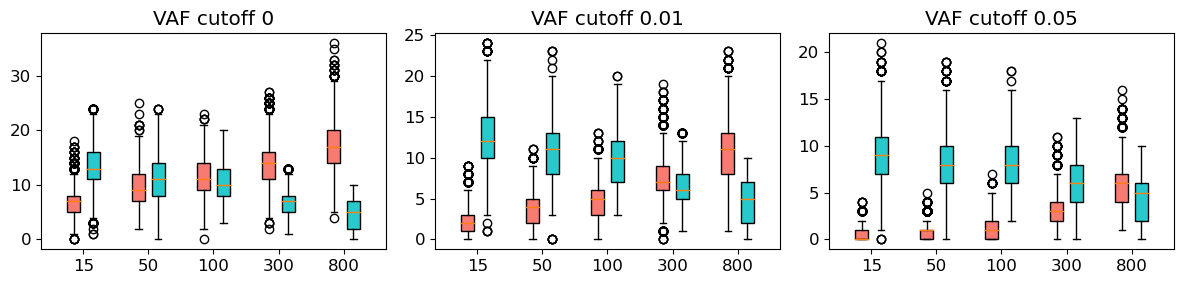

In [112]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
xrange=np.arange(1, 6)
for ind, cutoff in enumerate([0,0.01,0.05]):
    de_data = []
    pre_data = []
    for gen in [15, 50, 100, 300, 800]:
        pre_data.append(res[gen][cutoff]['pre'])
        de_data.append(res[gen][cutoff]['de'])
    bp1 = ax[ind].boxplot(de_data, positions=xrange-0.15, patch_artist=True, widths=0.2)
    bp2 = ax[ind].boxplot(pre_data, positions=xrange+0.15, patch_artist=True, widths=0.2)
    for patch in bp1['boxes']:
        patch.set_facecolor('#f87b72')
    for patch in bp2['boxes']:
        patch.set_facecolor('#28c9cd')
    ax[ind].set_xticks(xrange, [15, 50, 100, 300, 800])
    # ax[ind].set_yscale('log')
    ax[ind].set_title(f'VAF cutoff {cutoff}')
# fig.suptitle('De novo')
plt.tight_layout()

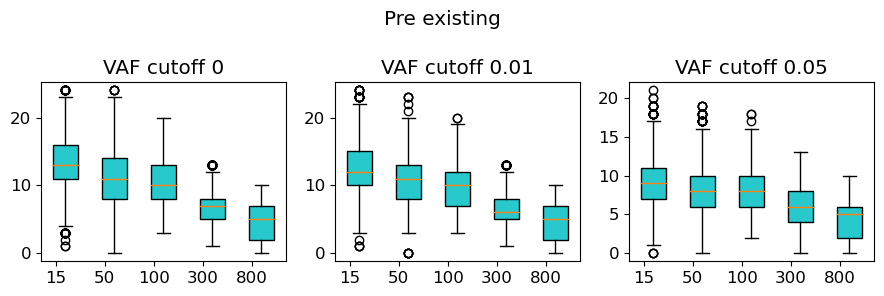

In [104]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
xrange=np.arange(1, 6)
for ind, cutoff in enumerate([0,0.01,0.05]):
    de_data = []
    pre_data = []
    for gen in [15, 50, 100, 300, 800]:
        pre_data.append(res[gen][cutoff]['pre'])
        de_data.append(res[gen][cutoff]['de'])
    # bp1 = ax[ind].boxplot(de_data, positions=xrange-0.2, patch_artist=True)
    bp2 = ax[ind].boxplot(pre_data, positions=xrange+0.2, patch_artist=True)
    # for patch in bp1['boxes']:
    #     patch.set_facecolor('#f87b72')
    for patch in bp2['boxes']:
        patch.set_facecolor('#28c9cd')
    ax[ind].set_xticks(xrange, [15, 50, 100, 300, 800])
    # ax[ind].set_yscale('log')
    ax[ind].set_title(f'VAF cutoff {cutoff}')
fig.suptitle('Pre existing')
plt.tight_layout()

In [126]:
def sparse_freq(cells, df=True):
    cell_names = list(cells.keys())
    max_mut_id = max([max([max(list(i)+[0]) for i in cells[j]]+[0]) for j in cell_names])
    
    _row, _col, _data = [], [], []
    with tqdm(total=len(cell_names)) as pbar:
        for ind, cell in enumerate(cells):
            cell_muts = sum([list(i) for i in cells[cell]], [])
            nmts = len(cells[cell])
            cnt = Counter(cell_muts)
            for mut in cnt:
                _col.append(mut)
                _row.append(ind)
                _data.append(cnt[mut]/nmts)
            pbar.update(1)
    freq = coo_matrix((_data, (_row, _col))).tocsr()
    mut_id = np.arange(freq.shape[1])
    sel = np.array(freq.sum(axis=0)!=0).flatten()
    mut_id = mut_id[sel]
    freq = freq[:, sel]
    if df:
        freq = pd.DataFrame(freq.A, index=cell_names, columns=mut_id)
    return freq, cell_names,mut_id

In [127]:
freq = sparse_freq(mt)

  0%|          | 0/4048 [00:00<?, ?it/s]

In [128]:
freq

,0,1,2,4,5,7,8,9,10,11,...,5820877,5820878,5820880,5820881,5820882,5820884,5820885,5820886,5820888,5820889
<29_384>_0,0.801709,0.801709,0.0,0.0,0.0,0.000000,0.000000,0.201709,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
<29_384>_1,0.759934,0.759934,0.0,0.0,0.0,0.000000,0.000000,0.100993,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
<29_384>_2,0.778388,0.778388,0.0,0.0,0.0,0.000000,0.000000,0.130037,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
<29_384>_3,0.778689,0.778689,0.0,0.0,0.0,0.000000,0.000000,0.180328,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
<29_384>_4,0.769366,0.769366,0.0,0.0,0.0,0.000000,0.000000,0.176056,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
<18_3509>_118,0.322851,0.322851,0.0,0.0,0.0,0.322851,0.322851,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.002096,0.000000,0.000000,0.000000,0.000000
<18_3509>_119,0.376033,0.376033,0.0,0.0,0.0,0.376033,0.376033,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.002066,0.002066,0.000000,0.000000
<18_3509>_120,0.334615,0.334615,0.0,0.0,0.0,0.334615,0.334615,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
<18_3509>_121,0.336364,0.336364,0.0,0.0,0.0,0.336364,0.336364,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.002273,0.002273


In [130]:
np.random.binomial(1, 0.5, 10).sum()

5

In [54]:
mut_freq = []
mt = pickle.load(open('/data3/wangkun/mtsim_res/res_1113/linear_/449346/mt_allmuts_mid_0.1_449346.pkl', 'rb'))
tree = Phylo.read(f'/data3/wangkun/mtsim_res/res_1113/linear_/449346/linear_tree_gt_449346.nwk', format='newick')

sel_cells = [i.name for i in tree.get_terminals()]
max_mut_id = max([max([max(list(i)+[0]) for i in mt[j]]+[0]) for j in sel_cells])


In [55]:
new_mts_1 = dict()
for cell in tree.get_terminals():
    new_mts_1[cell.name] = mt[cell.name]
mut_freq.append(sparse_freq(new_mts_1))
for _ in range(12):
    for cell in tree.get_terminals():
        new_mts_1[cell.name] = new_mts_1[cell.name]
        tmp = cell_division_with_mt1(new_mts_1[cell.name] ,max_mut_id, 0.8, 2.2)
        max_mut_id = tmp[-1]
        new_mts_1[cell.name] = tmp[0]
    mut_freq.append(sparse_freq(new_mts_1))
    

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [59]:
mf.shape

(5000, 102255)

In [63]:
mut_freq[0].shape

(5000, 6457)

In [61]:
mut_freq[1].shape

(5000, 14409)

In [62]:
mut_freq[2].shape

(5000, 22431)

In [65]:
np.sum(mf>0, axis=1).

(5000, 1)

In [56]:
dn0, dn1, dn5 = [], [], []
for mf in mut_freq:
    dn0.append(np.array(np.sum(mf>0, axis=1)).flatten())
    dn1.append(np.array(np.sum(mf>0.01, axis=1)).flatten())
    dn5.append(np.array(np.sum(mf>0.05, axis=1)).flatten())

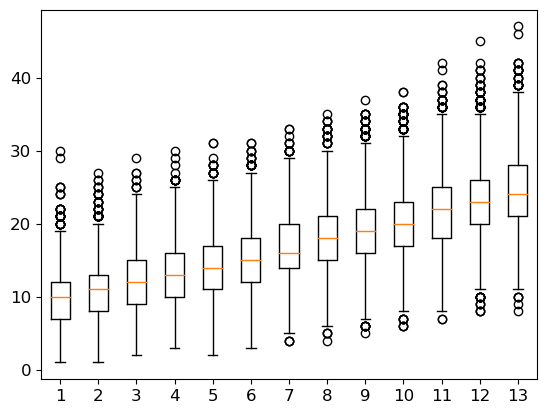

In [58]:
bp = plt.boxplot(dn0)